In [1]:
from typing import List

import math
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pickle
import bz2

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, LlamaForCausalLM

In [10]:
# img = cv2.imread("./ILSVRC2012_val_00003014.JPEG", cv2.IMREAD_COLOR)
# img = cv2.resize(img, (224, 224))

img = cv2.imread("./0000.jpg", cv2.IMREAD_COLOR)

img.shape, img.dtype

((32, 32, 3), dtype('uint8'))

In [11]:
class LLMCompression:

	def __init__(self,
		llm_name: str,
		context_size: int,
		patch_size: int, # context_window: int,
		color_sep: str="-",
		pixel_sep: str="|",
		m_batches: int=4,
	):
		self.llm_name = llm_name
		self.llm = AutoModelForCausalLM.from_pretrained(
			llm_name,
			# torch_dtype=torch.bfloat16,
			torch_dtype=torch.float32,
			low_cpu_mem_usage=True,
			# load_in_4bit=True,
			# quantization_config=quantization_config,
			# device_map=torch.device("cuda"),
			device_map="auto"
			# device_map="cpu"
		)
		self.llm.eval()
		for param in self.llm.parameters():
			param.requires_grad = False
		self.tokenizer = AutoTokenizer.from_pretrained(llm_name)

		self.m_batches = m_batches
		self.context_size = context_size
		self.patch_size = patch_size
		self.color_sep = color_sep
		self.pixel_sep = pixel_sep
		self.words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', self.color_sep, self.pixel_sep]
		self.tokens = self.tokenizer(self.words, add_special_tokens=False)
		self.tokens = [x for xs in self.tokens["input_ids"] for x in xs]

		self.word2token = {w: idx for w, idx in zip(self.words, self.tokens)}
		self.token2word = {idx: w for idx, w in zip(self.tokens, self.words)}
	
	# rank from "stable" sort
	def _get_rank(self, logits, token_ids):  # (B, N, V) (B, N)
		'''
			Rank: how many logits are larger than the token logits
			1/ The number of values less than token_ids
			2/ The number of values equal with token_ids
		'''
		# count the strictly the number of greater values
		selected_logits = logits.gather(-1, token_ids[..., None]).squeeze(-1)
		n_gt = (logits > selected_logits[..., None]).sum(-1)  # (B, N)

		# "mimic" stable sorting
		eq = logits.eq(selected_logits[..., None])  # (B, N, V)
		mask = torch.arange(logits.shape[-1], device=logits.device) < token_ids.unsqueeze(-1)
		n_eq = (eq*mask).sum(-1)

		return n_gt + n_eq
	
	def encode(self, img):
		p_size = self.patch_size
		m_batches = self.m_batches

		patches = np.array([
			img[i*p_size:(i+1)*p_size, j*p_size:(j+1)*p_size, :].flatten()
			for i in range(img.shape[0]//p_size)
			for j in range(img.shape[1]//p_size)
		])
		print("patches", patches.shape)

		tokens = self.patch2tokens(patches)
		tokens = tokens["input_ids"].squeeze()
		tokens = tokens.to(self.llm.device)
		print("tokens", tokens.shape)

		ranks = torch.empty([tokens.shape[0], tokens.shape[1]-1], requires_grad=False, dtype=torch.int64)
		for i in range(math.ceil(tokens.shape[0] // m_batches)):
			torch.cuda.empty_cache()
			_tokens = tokens[i*m_batches:(i+1)*m_batches]
			output = self.llm(_tokens[:, :-1], use_cache=False)
			ranks[i*m_batches:(i+1)*m_batches] = self._get_rank(output.logits, _tokens[:, 1:])
		h, w = img.shape[0] // p_size, img.shape[1] // p_size
		return ranks, h, w

	def decode(self, rank: List[int], h, w):  # (P, N)
		m_batches = self.m_batches
		patch_size = self.patch_size
		
		recon_tokens = torch.empty_like(rank)
		for i in range(math.ceil(rank.shape[0]) // m_batches):
			torch.cuda.empty_cache()
			_h, _w = i // w, i % w
			_rank = rank[i*m_batches:(i+1)*m_batches]

			generated_ids = torch.full((_rank.shape[0], 1), self.tokenizer.bos_token_id).cuda()
			
			past_key_values = None
			for idx in range(_rank.shape[-1]):
				output = self.llm(generated_ids, past_key_values=past_key_values, use_cache=False)
				past_key_values = output.past_key_values

				logits = output.logits[:, -1, :]  # shape: (n_chunks, vocab)
				logits, sorted_tokens = torch.sort(logits, descending=True, stable=True)

				next_token_id = sorted_tokens.gather(-1, _rank[:, idx].cuda().unsqueeze(-1))

				generated_ids = torch.cat([generated_ids, next_token_id], dim=1)
			recon_tokens[i*m_batches:(i+1)*m_batches] = generated_ids[:, 1:]
			
		# recon_img = np.empty((h*llm_zip.patch_size, w*llm_zip.patch_size, 3), dtype=np.uint8)
			# recon_img[_h*patch_size:(_h+1)*patch_size, _w*patch_size:(_w+1)*patch_size, :] = array
		return recon_tokens

	def evaluate(self, s):
		rank, pad_len = self.encode(s)
		torch.cuda.empty_cache()

		s_hat = self.decode(rank, pad_len)
		assert s_hat == s, f"incorrect (de)-compression \n Expected: {s} \n Got: {s_hat}"

		compressed_s = bz2.compress(s.encode('utf-8'))
		_rank = rank.flatten()
		compressed_s_hat = bz2.compress(_rank.cpu().numpy().tobytes())

		# Get the size of the compressed data
		s_size = len(compressed_s)
		s_hat_size = len(compressed_s_hat)
		# print(s_hat_size, s_size)
		print(f"Compression ratio: {(s_hat_size / s_size)*100:.4f}")

		return _rank, pad_len
	
	def patch2tokens(self, patches):
		sequences = [
			f'{self.pixel_sep}'.join([
				f'{self.color_sep}'.join([
					str(num) for num in patch[i*3:(i+1)*3]
				]) for i in range(len(patch)//3)
			])
			for patch in patches
		]
		return self.tokenizer(sequences, return_tensors="pt")
	
	def tokens2patch(self, tokens, h, w):
		p_size = llm_zip.patch_size
		patches = np.array([
			img[i*p_size:(i+1)*p_size, j*p_size:(j+1)*p_size, :].flatten()
			for i in range(img.shape[0]//p_size)
			for j in range(img.shape[1]//p_size)
		])
		print("patches", patches.shape)

		tokens = llm_zip.patch2tokens(patches)
		tokens = tokens["input_ids"].squeeze()
		tokens = tokens.to(llm_zip.llm.device)
		print("tokens", tokens.shape)

		decs = [
			llm_zip.tokenizer.decode(token, skip_special_tokens=True)
			for token in tokens
		]
		arrays = [
			np.array([
				d.split(llm_zip.color_sep)
				for d in dec.split(llm_zip.pixel_sep)
			]).reshape((llm_zip.patch_size, llm_zip.patch_size, 3))
			for dec in decs
		]

		recon_img = np.empty((h*llm_zip.patch_size, w*llm_zip.patch_size, 3), dtype=np.uint8)

		patch_size = llm_zip.patch_size
		for i, array in enumerate(arrays):
			_h, _w = i // w, i % w
			recon_img[_h*patch_size:(_h+1)*patch_size, _w*patch_size:(_w+1)*patch_size, :] = array
		return recon_img

llm_zip = LLMCompression(
	# llm_name="meta-llama/Llama-3.2-3B",
	llm_name="meta-llama/Llama-3.2-1B",
	# llm_name="unsloth/Llama-3.2-1B-bnb-4bit",
	context_size=256,
	patch_size=4,
	m_batches=8
)
ranks, h, w = llm_zip.encode(img)

patches (64, 48)
tokens torch.Size([64, 96])


In [12]:
recon_tokens = llm_zip.decode(ranks, h, w)

In [13]:
decs = [
	llm_zip.tokenizer.decode(token, skip_special_tokens=True)
	for token in recon_tokens
]
decs[0], decs[21]

('197-202-200|199-204-202|200-205-203|200-205-203|207-212-210|204-209-207|205-210-208|209-214-212|211-214-212|207-210-208|211-214-212|218-221-219|209-212-210|210-213-211|212-215-213|215-218-216',
 '148th birthday of the Holocaust Anniversaries\nThe 99th anniversary of the Holocaust\nThe first anniversary of the explosion of Operation Protective Edge\n7th anniversary of the assassination attempt on the President of the US\nThe 100th Syngma\nThe 215th birth anniversary of the Torah\nThe 100th commemoration of the death of Adam Weisel\n100th holocaust commemoration\nThe celebration of 100 years of Eretz Yis')

In [15]:

arrays = [
	np.array([
		d.split(llm_zip.color_sep)
		for d in dec.split(llm_zip.pixel_sep)
	])#.reshape((llm_zip.patch_size, llm_zip.patch_size, 3))
	for dec in decs
]
for array in arrays:
    print(array.shape)

(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(1, 1)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)
(16, 3)


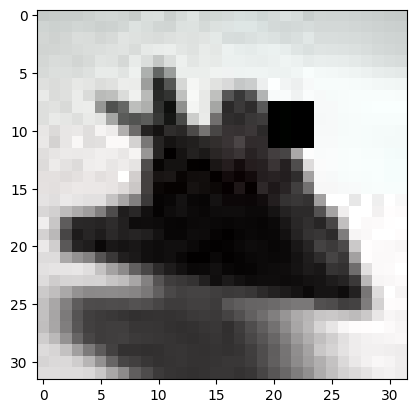

In [16]:

arrays = [
	np.array([
		d.split(llm_zip.color_sep)
		for d in dec.split(llm_zip.pixel_sep)
	])#.reshape((llm_zip.patch_size, llm_zip.patch_size, 3))
	for dec in decs
]

recon_img = np.empty((h*llm_zip.patch_size, w*llm_zip.patch_size, 3), dtype=np.uint8)

patch_size = llm_zip.patch_size
for i, array in enumerate(arrays):
	_h, _w = i // w, i % w
	if array.shape == (1, 1): continue
	recon_img[_h*patch_size:(_h+1)*patch_size, _w*patch_size:(_w+1)*patch_size, :] = array.reshape((llm_zip.patch_size, llm_zip.patch_size, 3))
plt.imshow(recon_img)
plt.show()

In [ ]:
patches[21]

In [ ]:
h, w = img.shape[0] // llm_zip.patch_size, img.shape[1] // llm_zip.patch_size

p_size = llm_zip.patch_size
patches = np.array([
	img[i*p_size:(i+1)*p_size, j*p_size:(j+1)*p_size, :].flatten()
	for i in range(img.shape[0]//p_size)
	for j in range(img.shape[1]//p_size)
])
print("patches", patches.shape)

tokens = llm_zip.patch2tokens(patches)
tokens = tokens["input_ids"].squeeze()
tokens = tokens.to(llm_zip.llm.device)
print("tokens", tokens.shape)

decs = [
    llm_zip.tokenizer.decode(token, skip_special_tokens=True)
    for token in tokens
]
arrays = [
    np.array([
        d.split(llm_zip.color_sep)
    	for d in dec.split(llm_zip.pixel_sep)
	]).reshape((llm_zip.patch_size, llm_zip.patch_size, 3))
    for dec in decs
]

recon_img = np.empty((h*llm_zip.patch_size, w*llm_zip.patch_size, 3), dtype=np.uint8)

patch_size = llm_zip.patch_size
for i, array in enumerate(arrays):
    _h, _w = i // w, i % w
    recon_img[_h*patch_size:(_h+1)*patch_size, _w*patch_size:(_w+1)*patch_size, :] = array
plt.imshow(recon_img)
plt.show()

In [ ]:
recon_img.shape, img.shape, recon_img.dtype, img.dtype

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
%timeit llm_zip.encode(img)

In [ ]:
%timeit llm_zip.decode(rank, pad_len)

In [ ]:
words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '.', '-', "|"]
tokens = llm_zip.tokenizer(words, add_special_tokens=False)
tokens = [x for xs in tokens["input_ids"] for x in xs]

word2token = {w: idx for w, idx in zip(words, tokens)}
token2word = {idx: w for idx, w in zip(tokens, words)}
word2token, token2word

In [ ]:
l = ranks.flatten().tolist()

In [ ]:
len(bz2.compress(pickle.dumps(l)))

In [ ]:
len(bz2.compress(img))

In [ ]:
len(bz2.compress(pickle.dumps([0 for _ in range(10)])))